In [1]:
from phantominator import shepp_logan
from PIL import Image, ImageOps
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 

## Shepp Logan Phantom

In [ ]:
ph = shepp_logan(128)
ph = np.array((ph*255).astype(np.uint8))
im = Image.fromarray(ph,'L')

In [ ]:
im.show()

## IXI Dataset

### Undersampling k-space

In [2]:
import nibabel as nib
import glob
from numpy import fft
from PIL import Image, ImageOps
import nibabel as nib
import scipy.io

In [ ]:
img_paths = (glob.glob(f".\\IXI-T1\\*.nii.gz"))
training_data = list()
#im_arr = nib.load('1.nii').get_data()
for index, img_path in enumerate(img_paths):
    img = nib.load(img_path)
    im_arr = np.array(img.dataobj)
    # Select central slice
    im_center = im_arr[:,int(im_arr.shape[1]/2),:]
    im_center_scaled = ((im_center - np.min(im_center)) * (1/(np.max(im_center) - np.min(im_center)) * 255)).astype('uint8')
    #print(im_center_scaled.shape)
#     plt.imshow(im_center_scaled, cmap='gray',vmin = 0, vmax = 255)
#     plt.show()
    temp = im_center_scaled
    if temp.shape[1] != 256: #pad it if it is not 256x150
        temp = np.zeros((256,256))
        temp[:, int((256-im_center_scaled.shape[1])/2):256 - int((256-im_center_scaled.shape[1])/2)] = im_center_scaled
        
    training_data.append(temp) 
    #plt.imshow(im_center_scaled, cmap='gray', vmin=0, vmax=255)
    #plt.show()

In [95]:
def fft2c(im):
    d = fft.fftshift(fft.fft2(fft.ifftshift(im)))
    return d

def ifft2c(d):
    im = fft.fftshift(fft.ifft2(fft.ifftshift(d)))
    return im

def undersample(im, Rx, Ry, calibx, caliby):
    #M_u = np.zeros((im.shape[0],im.shape[1]))
    im_u = np.zeros((im.shape[0],im.shape[1]))
    #autocalibration = np.zeros((calibx,caliby));
    d = fft2c(im/255) #take the centered fft using fft package of numpy
    
    center_x1 = int(im.shape[0]/2 - (calibx/2 - 1))
    center_x2 = int(im.shape[0]/2 + (calibx/2))
    
    center_y1 = int(im.shape[1]/2 - (caliby/2 - 1))
    center_y2 = int(im.shape[1]/2 + (caliby/2))
    
    temp_u = np.zeros((im.shape[0],im.shape[1]), dtype = 'complex_')
#     plt.imshow(np.log(np.absolute(temp_u)+1),cmap='gray')
#     plt.show()
    
    for i_x in range(0,im.shape[0], Rx):
        for i_y in range(0, im.shape[1], Ry):
            temp_u[im.shape[0]-1-i_x,im.shape[1]-1-i_y] = d[im.shape[0]-1-i_x,im.shape[1]-1-i_y]
    
    #autocalibration[:,:] = d[center_x1-1:center_x2,center_y1-1:center_y2]
    temp_u[center_x1-1:center_x2,center_y1-1:center_y2] = d[center_x1-1:center_x2,center_y1-1:center_y2]
    #plt.imshow(np.log(np.absolute(temp_u)+1),cmap='gray')
    #plt.show()
    M_u_real = temp_u.real
    #print(np.all(M_u_real!=0))
    M_u_imag = temp_u.imag
    #print(M_u_imag)
    #M_u[:,:] = temp_u
    im_u = abs(ifft2c(temp_u))
    #plt.imshow(np.absolute(im_u),cmap='gray')
    #plt.show()
    return temp_u, M_u_real, M_u_imag, im_u

### Reading Data from Folder and Constructing the training data

In [30]:
from scipy.io import loadmat

In [81]:
Rx = 1
Ry = 3 
calibx = 60
caliby = 60
x = loadmat('ixi-t1_final.mat')['imdata']
imdata = np.array(x)
imdata.shape

(581, 256, 256)

In [99]:
training_data = np.zeros((500,256*256))
training_data_k_space = np.zeros((500,256*256*2))
for i_train in range(500):
    im = imdata[i_train,:,:]
    k_u, k_ur, k_ui, im_u = undersample(im, Rx, Ry, calibx, caliby)
    im_u_reshape = np.reshape(im_u, (1,256*256))
    k_ur_reshape = np.reshape(k_ur, (1,256*256))
    k_ui_reshape = np.reshape(k_ui, (1,256*256))
    
    training_data[i_train,:] = im_u_reshape
    training_data_k_space[i_train,:] = np.concatenate((k_ur_reshape,k_ui_reshape),axis=1)

np.savez('train_data.npz', train = training_data)
np.savez('train_data_kspace.npz', train = training_data_k_space)

test_data = np.zeros((81,256*256))
test_data_k_space = np.zeros((81,256*256*2))
for i_test in range(81):
    im = imdata[i_test + 500,:,:]
    k_u, k_ur, k_ui, im_u = undersample(im, Rx, Ry, calibx, caliby)
    im_u_reshape = np.reshape(im_u, (1,256*256))
    k_ur_reshape = np.reshape(k_ur, (1,256*256))
    k_ui_reshape = np.reshape(k_ui, (1,256*256))
    
    test_data[i_test,:] = im_u_reshape
    test_data_k_space[i_test,:] = np.concatenate((k_ur_reshape,k_ui_reshape),axis=1)

np.savez('test_data.npz', test = test_data)
np.savez('test_data_kspace.npz', test = test_data_k_space)

In [35]:
for i_fold in range(10):
    train = list()
    x = loadmat('train_im_'+ str(i_fold+1)+'.mat')['im']
    #x = loadmat('test_im.mat')['im']
    print('train_im_'+ str(i_fold+1)+'.mat is processing')
    train_im = np.array(x)
    
    for i_sample in range(train_im.shape[0]):
        feature_vector = np.zeros((16,train_im_1.shape[1]*train_im_1.shape[1]))
        
        index = 0
        for i_coil in range(8):
            coil_im = train_im[i_sample,:,:,i_coil]
            #print(np.amax(coil_im))
            M_u, M_u_real, M_u_imag = undersample(coil_im, Rx, Ry, calibx, caliby)
            #plt.imshow(np.log(np.absolute(M_u)+1),cmap='gray') #check k-space
            #plt.show()
            M_u_real = np.reshape(M_u_real,(1,M_u_real.shape[0]*M_u_real.shape[1]))
            feature_vector[index,:] = M_u_real
            index += 1
        
            M_u_imag = np.reshape(M_u_imag,(1,M_u_imag.shape[0]*M_u_imag.shape[1]))
            feature_vector[index,:] = M_u_imag
            index += 1
    
        train.append(feature_vector)
    
    np.savez('train_im_'+ str(i_fold+1)+'.npz', train = train)

train_im_1.mat is processing
train_im_2.mat is processing
train_im_3.mat is processing
train_im_4.mat is processing
train_im_5.mat is processing
train_im_6.mat is processing
train_im_7.mat is processing
train_im_8.mat is processing
train_im_9.mat is processing
train_im_10.mat is processing


3121.3531845435896


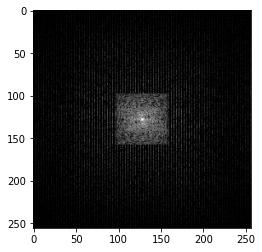

In [78]:
coil_im = traind[38,4,:]
coil_im = np.reshape(coil_im,(256,256))
print(np.amax(coil_im))
plt.imshow(np.log(np.absolute(coil_im)+1),cmap='gray') #check k-space
plt.show()